### SetUP

In [0]:
# connect to google drive
import os
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# change root directory such that models are saved in google drive during training
root_dir = "/content/gdrive/My Drive/DeepFLY"
os.chdir(root_dir)
# print the contents
!ls

all_attractions.pkl  LP_Scrape.ipynb	scrape_data_with_apify.ipynb
all_reviews.pkl      poi_database.json	TA_scrape.ipynb
apify_data	     poi_japan.json	Travel-Rec-Sys.ipynb
EDA_deepFLY.ipynb    poi_thailand.json	Triposo_Scrape.ipynb


### Imports

In [0]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import sleep
import sys
import re
import shutil
import json
from tqdm import tqdm_notebook
import operator
from collections import OrderedDict
import pickle
import itertools
import gc

%matplotlib inline

In [0]:
import spacy
nlp = spacy.load('en_core_web_sm')

### Load data

In [0]:
all_reviews = pd.read_pickle('all_reviews.pkl')
all_att = pd.read_pickle('all_attractions.pkl')

In [72]:
print("{} Attractions extracted from TA".format(len(all_att)))
print("{} reviews extracted from TA".format(len(all_reviews)))

109333 Attractions extracted from TA
2549347 reviews extracted from TA


### EDA

#### Attractions EDA

In [0]:
### Additional features
def split_try(x):
  try:
    y = x.split(',')
  except:
    return ['default']
  return y
###
def composite_cat(x):
  L = []
  for macro in x[0]:
    for micro in x[1]:
      L.append('_'.join([macro, micro]))
  return L
####

all_att['macro_cats'] = all_att['category_names'].apply(lambda x: x.split(','))
all_att['micro_cats'] = all_att['subtype_names'].apply(lambda x:split_try(x))
all_att = all_att.drop(columns = ['category_names','subtype_names'], axis = 1)

all_att['meta'] = all_att[['macro_cats','micro_cats']].apply(composite_cat, axis = 1)

In [82]:
### Find all meta classes
meta_list = list(itertools.chain.from_iterable(all_att['meta'].values))
print('total number of attractions type: {}'.format(len(set(meta_list))))

total number of attractions type: 1745


In [0]:
meta_freq = {}

for i in range(len(all_att)):
  i_meta = all_att.iloc[i].meta
  for item in i_meta:
    if item in meta_freq.keys():
      meta_freq[item] += 1
    else:
      meta_freq[item] = 1
  

In [89]:
cut_off = 50
meta_keep = []
for k,v in meta_freq.items():
  if v >= cut_off:
    meta_keep.append(k)
##
print("retained meta categories = {} with cutoff = {}".format(len(meta_keep), cut_off))

retained meta categories = 591 with cutoff = 50


In [114]:
idx = 250
key = meta_keep[idx]
print('Number of attractions in category: {} = {}'.format(key,meta_freq[key]))

Number of attractions in category: Transportation_Walking Tours = 252


#### EDA Reviews

In [0]:
### Number of users with more than eq to N reviews
## Group reviews by user
review_grps = all_reviews.groupby('user')
users_list = []
### Make a list of users with more than n reniews
n = 5
for name, grp in review_grps:
  if(grp['location_id'].nunique()>=n):
    users_list.append(name)
##
print('Number of users with more than {} reviews = {}'.format(n,len(users_list)))

Number of users with more than 5 reviews = 36518


In [0]:
## Check reviews by a particular user
idx = 4346
uname = users_list[idx]
un_commnets = review_grps.get_group(uname)
un_commnets = un_commnets.drop_duplicates(subset='location_id')
print('{} has commented {} times'.format(uname, un_commnets['location_id'].nunique()))
un_commnets.sample(min(len(un_commnets), 30))

Bluesphynx has commented 5 times


,comment,location_id,location_name,rating,title,user
166658,"After reading many reviews, found the most fav...",6211527,M. K. Spa Luang Prabang,5,"Dedicated masseuse, clean and well-run place",Bluesphynx
156924,Most places in Luang Prabang are not air-condi...,325309,Royal Palace Museum,3,Heat spoils enjoyment of the museum,Bluesphynx
158397,"Been to many, including Taiwan's famed night m...",1727836,Luang Prabang Night Market,5,Best night market ever,Bluesphynx
159411,"Whatever one's religion, any visitor will be t...",2229605,Alms Giving Ceremony,5,Touching and meaningful experience,Bluesphynx
160419,Got a good deal for an excursion here at 11.30...,555731,Kuang Si Falls,4,Beautiful but not really suitable for a dip,Bluesphynx


In [0]:
### Distributions with number of columns
list_num_comments =[]
for name in users_list:
  cmnt = review_grps.get_group(name)
  list_num_comments.append(cmnt['location_id'].nunique())

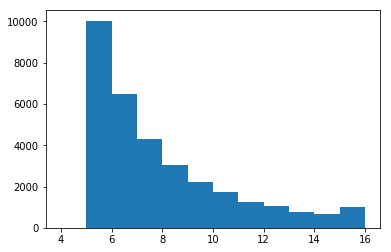

In [0]:
# Plot histogram
plt.hist(np.array(list_num_comments),  bins=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]);

In [0]:
### Filter reviews: all distinct + for users who commented at least 5 times
list_user_reviews =[]
for name in users_list:
  cmnt = review_grps.get_group(name)
  cmnt = cmnt.drop_duplicates(subset='location_id')
  list_user_reviews.append(cmnt)
###


In [0]:
# create dataframe
clean_reviews = pd.concat(list_user_reviews, ignore_index = True)
print('Number of clean reviews = {}'.format(len(clean_reviews)))

Number of clean reviews = 368500


In [0]:
clean_reviews.sample(5)

,comment,location_id,location_name,rating,title,user
44712,"My girlfriend and I went for a massage, and li...",12976292,Maison Spa Da Nang,5,BEST MASSAGE OF MY LIFE,Brandon R
241082,We researched many different scuba companies b...,1177013,Thailand Divers - Phuket Scuba Diving,5,Great Daytrip - We booked through Sunrise Dive...,T m
150622,I had no expectations for the caves although I...,148299,Harrison's Cave,4,It was interesting,Lets_Island_Hop_
366694,I had such a wonderful time running around the...,1084937,Highland Experience Tours,5,Highland Cows!!!,yancetta
6799,This is a lovely island and not too far to tra...,8028225,Koh Larn,4,A short ferry ride from Pattaya,446Sha


In [0]:
clean_reviews['rating'] = clean_reviews['rating'].apply(lambda x: int(x))

clean_reviews['rating'].describe()

count    368500.000000
mean          4.363970
std           0.890799
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

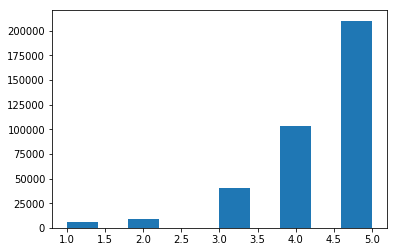

In [0]:
plt.hist(clean_reviews['rating']);

In [0]:
###### <<< ---- >>> ####